<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ARIMAX with Selected Features (E)</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Fixed Window Forecasting</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_all_rolling_stats_merged_2021_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181
season_24_ngames = 691

In [4]:
# load the best features dictionaries back from the file
with open('../../data/selected_features/feature_set_01_filter_and_wrapper.json', 'r') as json_file:
    selected_features_filter_and_wrapper = json.load(json_file)

with open('../../data/selected_features/feature_set_02_embedded.json', 'r') as json_file:
    selected_features_embedded = json.load(json_file)

In [5]:
# subset the features
pts_sub_fw_features = pts_all_features[selected_features_filter_and_wrapper['TOTAL_PTS'] + ['TOTAL_PTS']]
pts_sub_e_features = pts_all_features[selected_features_embedded['TOTAL_PTS'] + ['TOTAL_PTS']]

pm_sub_fw_features = pm_all_features[selected_features_filter_and_wrapper['PLUS_MINUS'] + ['PLUS_MINUS']]
pm_sub_e_features = pm_all_features[selected_features_embedded['PLUS_MINUS'] + ['PLUS_MINUS']]

res_sub_fw_features = res_all_features[selected_features_filter_and_wrapper['GAME_RESULT'] + ['GAME_RESULT']]
res_sub_e_features = res_all_features[selected_features_embedded['GAME_RESULT'] + ['GAME_RESULT']]

In [6]:
pts_sub_fw_features.head()

,ROLL_HOME_FTM,ROLL_HOME_OPP_PTS_PAINT,ROLL_HOME_PTS_PAINT,ROLL_AWAY_PTS,ROLL_HOME_PTS_FB,ROLL_AWAY_OFF_LOOSE_BALLS_RECOVERED,ROLL_AWAY_DEF_BOXOUTS,ROLL_AWAY_estimatedPace,ROLL_AWAY_PTS_PAINT,ROLL_AWAY_DFG_PCT,ROLL_HOME_AST,ROLL_AWAY_assistToTurnover,ROLL_HOME_OPP_TOV_PCT,ROLL_HOME_estimatedDefensiveRating,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,
2021-10-23,0.805,0.808,0.50,0.577,1.000,0.60,0.208,0.443,0.391,1.000,0.612,0.291,0.840,0.298,185
2021-10-23,0.466,0.758,0.25,0.096,0.581,0.30,0.307,0.522,0.000,0.453,0.000,0.161,0.762,0.176,198
2021-10-23,0.593,0.505,0.70,0.635,0.065,0.75,0.208,0.465,0.565,0.023,0.561,0.589,0.144,0.717,239
2021-10-23,0.297,0.606,0.70,0.250,0.839,0.30,0.109,0.691,0.261,0.965,0.918,0.218,0.519,0.328,232
2021-10-24,0.254,0.202,0.70,1.000,0.548,0.45,0.455,0.646,0.348,0.732,0.765,0.393,0.591,0.002,204


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [7]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pts_sub_e_features.drop('TOTAL_PTS', axis=1),
    pts_sub_e_features['TOTAL_PTS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 12) (2367,) (691, 12) (691,)


In [8]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 480.62 seconds


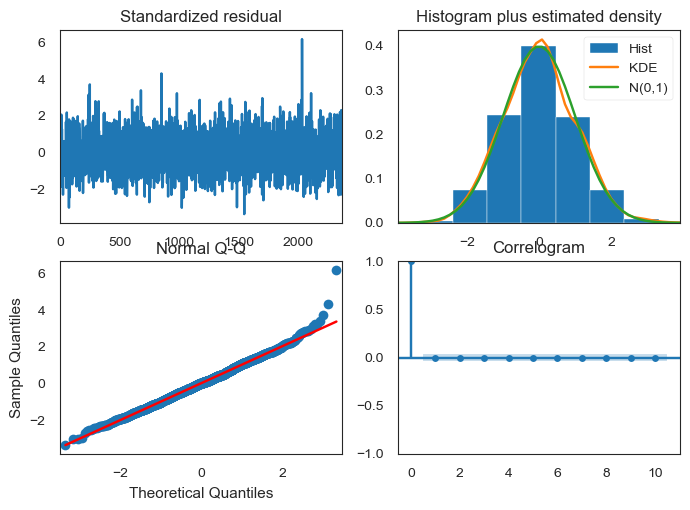

In [9]:
model1.plot_diagnostics();

In [10]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:              SARIMAX(16, 1, 1)   Log Likelihood              -10312.818
Date:                Thu, 04 Apr 2024   AIC                          20687.636
Time:                        19:33:13   BIC                          20866.474
Sample:                             0   HQIC                         20752.744
                               - 2367                                         
Covariance Type:                  opg                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                              0.0037      0.006      0.574      0.566      -0.009       0.016
ROLL_AWAY_DFG_PCT                     -1.1988      3.270     -0.367      0.714      -7.607       5.210
ROLL_HOME_PTS_PAINT                    3.8307      3.496      1.096      0.273      -3.021      10.683
ROLL_AWAY_assistToTurnover             4.2562      3.844      1.107      0.268      -3.278      11.791
ROLL_AWAY_OPP_PTS_PAINT                5.7910      3.536      1.638      0.101      -1.139      12.721
ROLL_HOME_FGM                          2.3747      7.468      0.318      0.750     -12.262      17.011
ROLL_AWAY_offensiveRating            -30.0162      7.553     -3.974      0.000     -44.820     -15.213
ROLL_HOME_OPP_PTS_PAINT                9.6898      2.917      3.322      0.001       3.973      15.406
ROLL_HOME_estimatedDefensiveRating    21.3222     15.125      1.410      0.159      -8.322      50.967
ROLL_HOME_defensiveRating             -5.1562     15.818     -0.326      0.744     -36.160      25.847
ROLL_HOME_PTS                          8.8353      6.471      1.365      0.172      -3.848      21.519
ROLL_AWAY_FGM                          2.1525      5.551      0.388      0.698      -8.727      13.032
ROLL_AWAY_PTS                         35.2004      8.290      4.246      0.000      18.953      51.448
ar.L1                                 -0.0261      0.021     -1.229      0.219      -0.068       0.015
ar.L2                                 -0.0293      0.022     -1.352      0.176      -0.072       0.013
ar.L3                                 -0.0185      0.021     -0.895      0.371      -0.059       0.022
ar.L4                                  0.0095      0.021      0.457      0.648      -0.031       0.050
ar.L5                                  0.0052      0.021      0.243      0.808      -0.036       0.047
ar.L6                                  0.0458      0.021      2.200      0.028       0.005       0.087
ar.L7                                 -0.0031      0.021     -0.148      0.882      -0.045       0.038
ar.L8                                 -0.0240      0.021     -1.146      0.252      -0.065       0.017
ar.L9                                 -0.0091      0.021     -0.436      0.663      -0.050       0.032
ar.L10                                 0.0196      0.022      0.905      0.366      -0.023       0.062
ar.L11                                -0.0057      0.020     -0.279      0.780      -0.046       0.034
ar.L12                                -0.0557      0.021     -2.607      0.009      -0.098      -0.014
ar.L13                                -0.0328      0.020     -1.639      0.101      -0.072       0.006
ar.L14                                 0.0064      0.020      0.311      0.756      -0.034       0.046
ar.L15                                 0.0189      0.022      0.858      0.391      -0.024       0.062
ar.L16                                -0.0217   

In [11]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 6.63 %
Root Mean Squared Error: 19.18


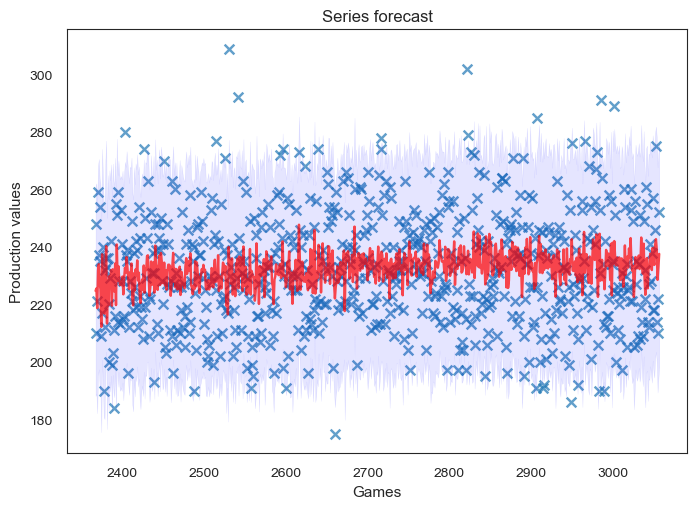

In [12]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pts_sub_fw_features['TOTAL_PTS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [13]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pm_sub_e_features.drop('PLUS_MINUS', axis=1),
    pm_sub_e_features['PLUS_MINUS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 14) (2367,) (691, 14) (691,)


In [14]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 27.48 seconds


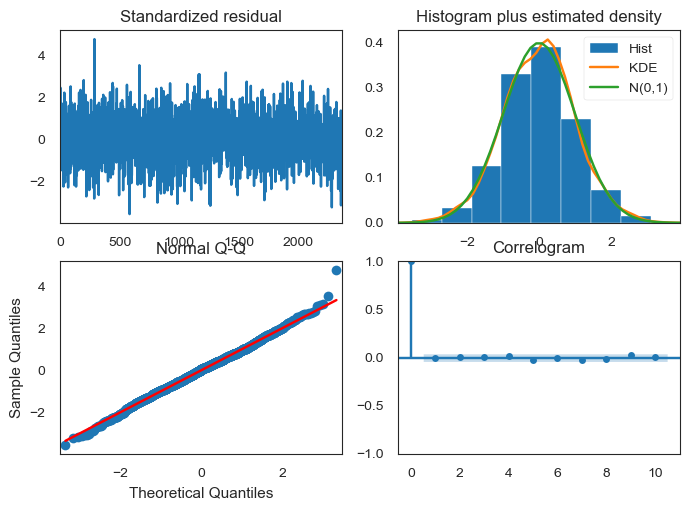

In [15]:
model1.plot_diagnostics();

In [16]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -9576.501
Date:                Thu, 04 Apr 2024   AIC                          19189.002
Time:                        19:33:41   BIC                          19292.851
Sample:                             0   HQIC                         19226.809
                               - 2367                                         
Covariance Type:                  opg                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
intercept                                  0.8078      0.845      0.956      0.339      -0.849       2.465
ROLL_HOME_netRating                       -9.2214     14.839     -0.621      0.534     -38.306      19.863
ROLL_HOME_PTS_PAINT                       -2.6442      2.872     -0.921      0.357      -8.274       2.985
ROLL_HOME_effectiveFieldGoalPercentage    -1.4494      3.539     -0.409      0.682      -8.387       5.488
ROLLDIFF_AWAY_PTS                         -7.9254      6.885     -1.151      0.250     -21.419       5.569
ROLLDIFF_HOME_FG_PCT                      -6.4386      3.551     -1.813      0.070     -13.399       0.522
ROLLDIFF_AWAY_FT_PCT                      -6.5617      1.949     -3.366      0.001     -10.383      -2.741
ROLLDIFF_HOME_PTS                         14.5074      6.752      2.149      0.032       1.274      27.741
ROLLDIFF_AWAY_AST                         -0.3346      2.244     -0.149      0.881      -4.732       4.063
ROLL_HOME_CFG_PCT                          7.6791      2.485      3.090      0.002       2.808      12.551
ROLL_HOME_estimatedNetRating              17.9047     12.989      1.378      0.168      -7.554      43.363
ROLL_HOME_CFGA                            -4.1996      2.617     -1.605      0.108      -9.328       0.929
ROLL_AWAY_estimatedNetRating             -15.9113     13.227     -1.203      0.229     -41.836      10.013
ROLL_AWAY_PIE                            -15.2508      9.955     -1.532      0.126     -34.761       4.260
ROLL_AWAY_netRating                       20.3901     14.589      1.398      0.162      -8.204      48.984
ar.L1                                      0.7916      0.141      5.629      0.000       0.516       1.067
ma.L1                                     -0.8240      0.130     -6.330      0.000      -1.079      -0.569
sigma2                                   191.2780      5.223     36.623      0.000     181.041     201.515
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                12.21
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.01
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 139.17 %
Root Mean Squared Error: 14.52


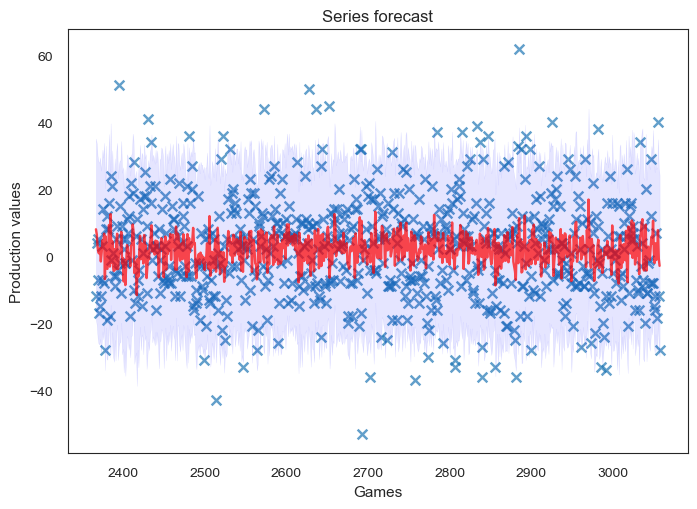

In [18]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pm_sub_fw_features['PLUS_MINUS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();